# Image Classification with Pre-trained models

Dataset: - CIFAR-10 from TensorFlow library
60000 imqges labeled in 10 classes - airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. Each image is 32x32.
Training dataset: 50000 images, Test dataset: 10000 images.

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import seaborn as sns

# Loading dataset

In [3]:
# Load the training/testing datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
# Check how many data points are loaded and their shape
print("x_train dimensions : ",x_train.shape)
print("x_test dimensions  : ",x_test.shape)
print("y_train dimensions : ",y_train.shape)
print("y_test dimensions  : ",y_test.shape)

x_train dimensions :  (50000, 32, 32, 3)
x_test dimensions  :  (10000, 32, 32, 3)
y_train dimensions :  (50000, 1)
y_test dimensions  :  (10000, 1)


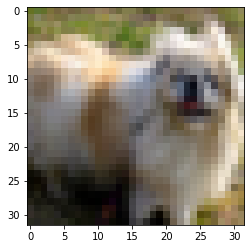

In [5]:
# print one sample data point
import matplotlib.pyplot as plt
plt.imshow(x_train[40])

# Preparing dataset

Reserve 5% of training data for validation

In [6]:
from sklearn.model_selection import train_test_split 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state = 0)

Augmentation 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
  rotation_range = 15,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True)

Normalization - color values range from 0 through 255.

In [8]:
def normalize(data):
    data = data.astype("float32")
    data = data/255.0
    return data

In [9]:
# Scale and agument train/test datasets
datagen.fit(x_train)
x_train = normalize(x_train)
x_val = normalize(x_val)
x_test = normalize(x_test)

Encode target column

In [10]:
y_train = tf.keras.utils.to_categorical(y_train , 10)
y_test  = tf.keras.utils.to_categorical(y_test , 10)
y_val = tf.keras.utils.to_categorical(y_val , 10)

In [11]:
# print the dimensions after the data preprocessing
print("x_train dimensions : ",x_train.shape)
print("y_train dimensions : ",y_train.shape)
print("x_test dimensions  : ",x_test.shape)
print("y_test dimensions  : ",y_test.shape)
print("x_val dimensions   : ",x_val.shape)
print("y_val dimensions   : ",y_val.shape)

x_train dimensions :  (47500, 32, 32, 3)
y_train dimensions :  (47500, 10)
x_test dimensions  :  (10000, 32, 32, 3)
y_test dimensions  :  (10000, 10)
x_val dimensions   :  (2500, 32, 32, 3)
y_val dimensions   :  (2500, 10)


# Modeling

We will experiment with the following models

- Our own CNN-based design
- Pre-trained VGG16
- Pre-trained Resnet50
- Pre-trained MobileNet
- Pre-trained DenseNet121


In [12]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Defining callbacks
A few callbacks to control training

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
        
callbacks = myCallback()

from keras.callbacks import ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=1, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.000001)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               min_delta=0.005,
                               patience=3, 
                               verbose=1, 
                               mode='auto')

Setting optimizer

In [14]:
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

## CNN

### Model building

In [15]:
model=Sequential()
model.add(Conv2D(64,(3,3),strides=1,padding='Same',activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation = "softmax"))

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                        

### Model training

In [17]:
epoch = 20
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32), 
                epochs = epoch, validation_data = (x_val, y_val), 
                verbose = 1, callbacks=[callbacks, lr_reduction, early_stopping])

Epoch 1/20
1485/1485 [==============================] - 43s 20ms/step - loss: 1.5231 - accuracy: 0.4676 - val_loss: 1.2653 - val_accuracy: 0.5408 - lr: 0.0010
Epoch 2/20
1485/1485 [==============================] - 26s 17ms/step - loss: 1.1822 - accuracy: 0.5781 - val_loss: 1.0477 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 3/20
1485/1485 [==============================] - 27s 18ms/step - loss: 1.0660 - accuracy: 0.6271 - val_loss: 0.9795 - val_accuracy: 0.6648 - lr: 0.0010
Epoch 4/20
1485/1485 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.6539
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1485/1485 [==============================] - 25s 17ms/step - loss: 0.9945 - accuracy: 0.6539 - val_loss: 1.0993 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 5/20
1485/1485 [==============================] - 25s 17ms/step - loss: 0.8700 - accuracy: 0.6939 - val_loss: 0.8112 - val_accuracy: 0.7196 - lr: 5.0000e-04
Epoch 6/20
1484/1485 [================

### Error metrics

In [18]:
# Plot accuracy and loss for training and validation sets

def plot_metrics(r):
  epoch_range = range(1, len(r.history['accuracy'])+1)
  plt.plot(epoch_range, r.history['accuracy'])
  plt.plot(epoch_range, r.history['val_accuracy'])
  plt.title('Classification Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range,r.history['loss'])
  plt.plot(epoch_range, r.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

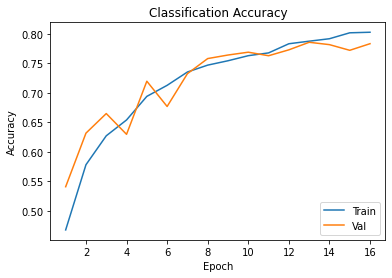

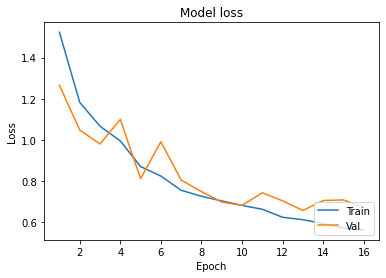

In [19]:
plot_metrics(history)

In [20]:
predicted_test_cnn = model.predict(x_val, batch_size=32)

In [21]:
class_pred_test_cnn = [np.argmax(i) for i in predicted_test_cnn]

In [22]:
y_val[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

Compute the argmax of the validation label so as to have both actual and predicted labels in same format and compute the error metrics as following.

In [23]:
[np.argmax(i) for i in y_val]

[7,
 5,
 5,
 6,
 5,
 4,
 3,
 0,
 7,
 2,
 5,
 0,
 3,
 4,
 9,
 2,
 4,
 7,
 7,
 5,
 5,
 4,
 1,
 9,
 3,
 9,
 6,
 2,
 3,
 5,
 5,
 1,
 5,
 4,
 2,
 3,
 8,
 9,
 5,
 7,
 1,
 9,
 8,
 0,
 3,
 1,
 2,
 7,
 9,
 1,
 4,
 0,
 7,
 1,
 6,
 9,
 9,
 8,
 0,
 2,
 0,
 2,
 2,
 0,
 8,
 3,
 4,
 7,
 2,
 0,
 6,
 8,
 0,
 4,
 7,
 1,
 9,
 5,
 7,
 7,
 4,
 5,
 9,
 9,
 4,
 6,
 3,
 0,
 6,
 2,
 9,
 2,
 7,
 4,
 2,
 5,
 6,
 7,
 3,
 4,
 1,
 0,
 8,
 4,
 8,
 4,
 2,
 9,
 7,
 1,
 9,
 9,
 6,
 0,
 1,
 8,
 3,
 1,
 7,
 0,
 3,
 0,
 0,
 3,
 6,
 8,
 0,
 5,
 7,
 7,
 5,
 6,
 7,
 0,
 0,
 9,
 7,
 4,
 3,
 1,
 1,
 5,
 3,
 4,
 2,
 9,
 2,
 8,
 6,
 6,
 0,
 2,
 7,
 6,
 1,
 1,
 0,
 0,
 8,
 6,
 2,
 8,
 1,
 6,
 5,
 2,
 6,
 8,
 9,
 7,
 7,
 6,
 1,
 6,
 6,
 2,
 4,
 2,
 3,
 2,
 7,
 7,
 6,
 4,
 3,
 9,
 3,
 7,
 1,
 2,
 4,
 5,
 1,
 7,
 0,
 0,
 1,
 1,
 5,
 9,
 2,
 1,
 8,
 7,
 9,
 5,
 5,
 0,
 6,
 3,
 2,
 0,
 2,
 6,
 0,
 6,
 2,
 5,
 6,
 6,
 1,
 9,
 2,
 1,
 9,
 5,
 8,
 8,
 5,
 2,
 1,
 7,
 9,
 5,
 9,
 0,
 0,
 3,
 1,
 9,
 7,
 9,
 6,
 2,
 8,
 0,
 5,
 4,
 0,
 1,


### Classification report

In [24]:
from sklearn.metrics import classification_report
report = classification_report([np.argmax(i) for i in y_val], class_pred_test_cnn)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       258
           1       0.88      0.90      0.89       252
           2       0.73      0.63      0.67       236
           3       0.70      0.56      0.63       286
           4       0.75      0.70      0.72       221
           5       0.76      0.64      0.70       282
           6       0.69      0.93      0.79       244
           7       0.78      0.87      0.82       240
           8       0.90      0.92      0.91       233
           9       0.83      0.88      0.85       248

    accuracy                           0.78      2500
   macro avg       0.78      0.79      0.78      2500
weighted avg       0.78      0.78      0.78      2500



### Confusion matrix

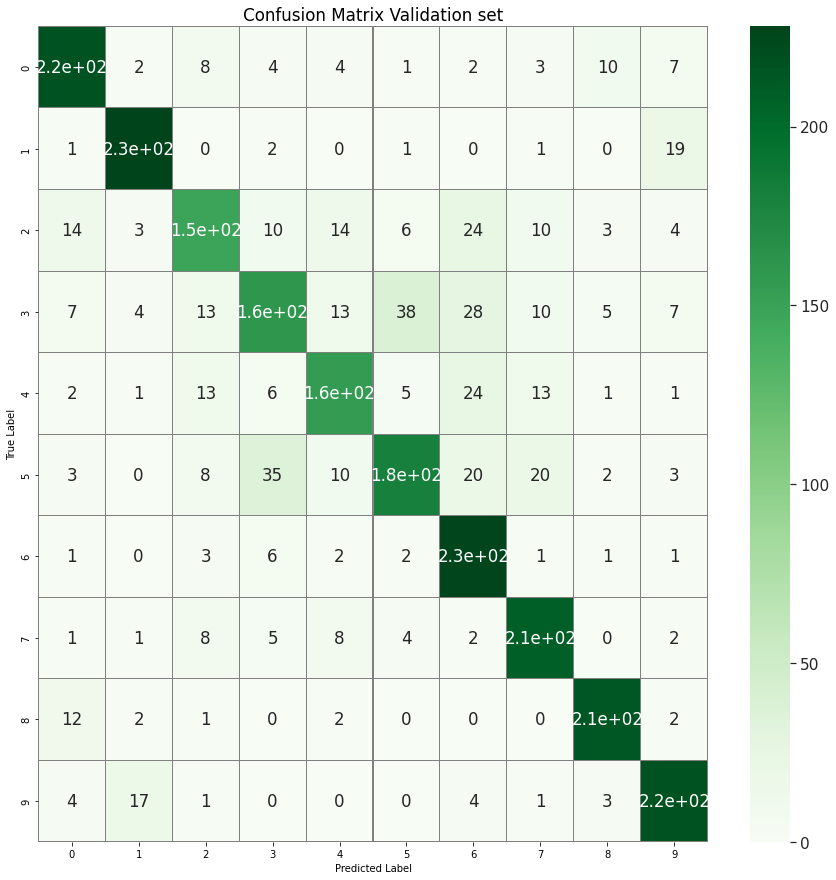

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx = confusion_matrix([np.argmax(i) for i in y_val], class_pred_test_cnn)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [26]:
acc = model.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

313/313 [==============================] - 1s 4ms/step - loss: 0.6916 - accuracy: 0.7827
test set loss :  0.6916284561157227
test set accuracy : 78.27000021934509


In [27]:
acc1 = model.evaluate (x_train, y_train)
print("training set loss : " , acc1[0])
print("training set accuracy :", acc1[1]*100)

1485/1485 [==============================] - 5s 3ms/step - loss: 0.4583 - accuracy: 0.8442
training set loss :  0.4582798480987549
training set accuracy : 84.42105054855347


### Inference:

In order to make this process a bit easier we will define a function which converts the image loaded to the proper size, dimensions and prints the class predicted followed by the probability of being such class and the image.

In [28]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array 

classes = ['airplane' ,'automobile', 'bird' , 'cat' , 'deer' ,'dog' ,'frog', 'horse' ,'ship' ,'truck']
def infer_class(filename , model):
  # load and display image
  img = load_img(filename, target_size=(32, 32))
  plt.imshow(img)

  # convert to array
  # reshape into a single sample with 3 channels
  img = img_to_array(img)
  img = img.reshape(1,32,32,3)

  # prepare pixel data
  img = img.astype('float32')
  img = img/255.0
  result = model.predict(img)

  # copy predictions to dictionary
  dict2 = {}
  for i in range(10):
      dict2[result[0][i]] = classes[i]

  # sort on predictions
  res = result[0]
  res.sort()

  res = res[::-1]
  results = res[0]

  print("The class predicted for the given image is:")
  print("{} : {}".format(dict2[results] , (results*100).round(2)))

The following lines of code have as purpose the load of the unseen images from a github repository, save as png format in content folder and call the function just defined to predict the class:

In [29]:
!wget "https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/unknown01.png"

--2022-09-08 07:57:56--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/unknown01.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62308 (61K) [image/png]
Saving to: ‘unknown01.png’

unknown01.png       100%[===================>]  60.85K  --.-KB/s    in 0.001s  

2022-09-08 07:57:57 (69.4 MB/s) - ‘unknown01.png’ saved [62308/62308]



In [30]:
!wget "https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/unknown02.png"

--2022-09-08 07:57:57--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/unknown02.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28117 (27K) [image/png]
Saving to: ‘unknown02.png’

unknown02.png       100%[===================>]  27.46K  --.-KB/s    in 0s      

2022-09-08 07:57:57 (119 MB/s) - ‘unknown02.png’ saved [28117/28117]



In [31]:
!wget "https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/unknown03.png"

--2022-09-08 07:57:57--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/unknown03.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92446 (90K) [image/png]
Saving to: ‘unknown03.png’

unknown03.png       100%[===================>]  90.28K  --.-KB/s    in 0.003s  

2022-09-08 07:57:57 (31.9 MB/s) - ‘unknown03.png’ saved [92446/92446]



The class predicted for the given image is:
airplane : 99.9


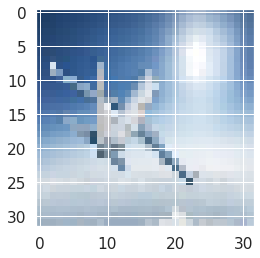

In [32]:
infer_class("/content/unknown01.png" , model)

The class predicted for the given image is:
automobile : 99.48


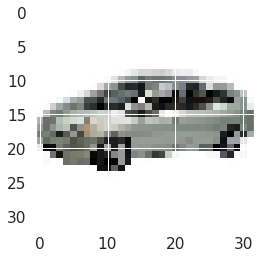

In [33]:
infer_class("/content/unknown02.png" , model)

The class predicted for the given image is:
bird : 99.53


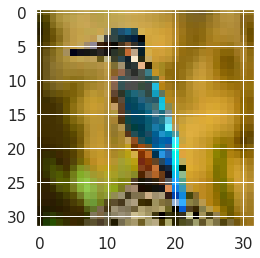

In [34]:
infer_class("/content/unknown03.png" , model)

## VGG16

In [35]:
from tensorflow.keras.applications import VGG16

In [36]:
model_VGG=Sequential()
model_VGG.add(VGG16(input_shape=(32,32,3),
                    include_top=False,
                    pooling='max',
                    weights='imagenet'))

58900480/58889256 [==============================] - 0s 0us/step


In [37]:
model_VGG.layers[0].trainable=False
model_VGG.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
model_VGG.add(Dense(512,activation='relu'))
model_VGG.add(Dropout(0.1))
model_VGG.add(Dense(10,activation='softmax'))

In [39]:
model_VGG.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [40]:
model_VGG.layers

In [41]:
model_VGG.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
epoch = 20
history3 = model_VGG.fit(datagen.flow(x_train, y_train, batch_size = 32), 
                         epochs = epoch, validation_data = (x_val, y_val), 
                        verbose = 1, callbacks=[callbacks, lr_reduction, early_stopping])

Epoch 1/20
1485/1485 [==============================] - 31s 20ms/step - loss: 1.8630 - accuracy: 0.3630 - val_loss: 1.6494 - val_accuracy: 0.4508 - lr: 1.5625e-05
Epoch 2/20
1485/1485 [==============================] - 28s 19ms/step - loss: 1.6590 - accuracy: 0.4312 - val_loss: 1.5404 - val_accuracy: 0.4756 - lr: 1.5625e-05
Epoch 3/20
1485/1485 [==============================] - 28s 19ms/step - loss: 1.5837 - accuracy: 0.4554 - val_loss: 1.4778 - val_accuracy: 0.5052 - lr: 1.5625e-05
Epoch 4/20
1485/1485 [==============================] - 29s 19ms/step - loss: 1.5343 - accuracy: 0.4696 - val_loss: 1.4390 - val_accuracy: 0.5112 - lr: 1.5625e-05
Epoch 5/20
1485/1485 [==============================] - 29s 20ms/step - loss: 1.5036 - accuracy: 0.4787 - val_loss: 1.4069 - val_accuracy: 0.5176 - lr: 1.5625e-05
Epoch 6/20
1485/1485 [==============================] - 29s 20ms/step - loss: 1.4744 - accuracy: 0.4908 - val_loss: 1.3811 - val_accuracy: 0.5292 - lr: 1.5625e-05
Epoch 7/20
1485/1485 [

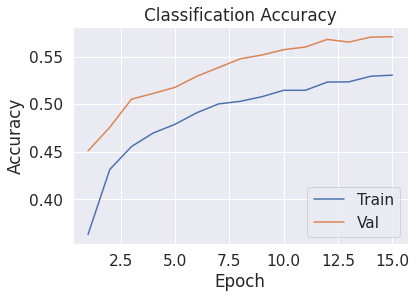

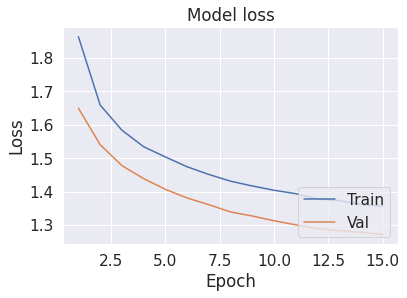

In [43]:
plot_metrics(history3)

In [44]:
predicted_test_VGG = model_VGG.predict(x_val, batch_size=32)

In [45]:
class_pred_test_VGG = [np.argmax(i) for i in predicted_test_VGG]

In [46]:
from sklearn.metrics import classification_report
report = classification_report([np.argmax(i) for i in y_val], class_pred_test_VGG)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       258
           1       0.59      0.65      0.62       252
           2       0.52      0.37      0.43       236
           3       0.53      0.36      0.43       286
           4       0.51      0.46      0.49       221
           5       0.59      0.51      0.55       282
           6       0.50      0.76      0.60       244
           7       0.56      0.61      0.58       240
           8       0.67      0.70      0.69       233
           9       0.60      0.63      0.62       248

    accuracy                           0.57      2500
   macro avg       0.57      0.57      0.57      2500
weighted avg       0.57      0.57      0.56      2500



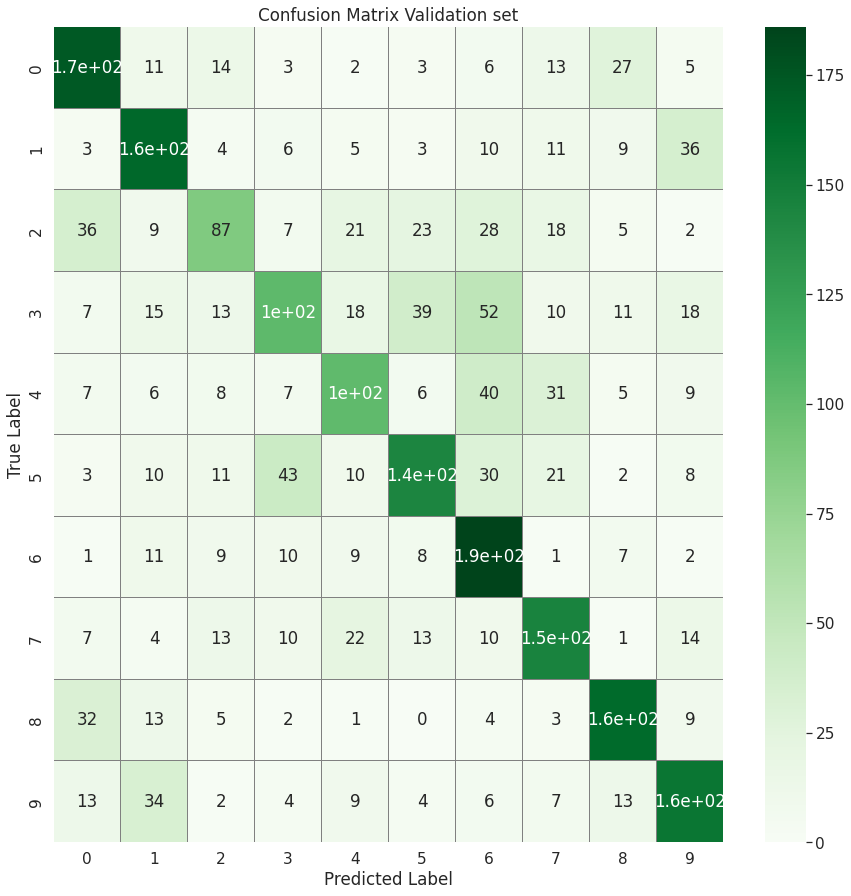

In [47]:
from sklearn.metrics import confusion_matrix

f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx = confusion_matrix([np.argmax(i) for i in y_val], class_pred_test_VGG)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [48]:
acc = model_VGG.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

313/313 [==============================] - 3s 10ms/step - loss: 1.2996 - accuracy: 0.5525
test set loss :  1.299589991569519
test set accuracy : 55.250000953674316


In [49]:
acc1 = model.evaluate (x_train, y_train)
print("training set loss : " , acc1[0])
print("training set accuracy :", acc1[1]*100)

1485/1485 [==============================] - 5s 3ms/step - loss: 0.4583 - accuracy: 0.8442
training set loss :  0.4582798480987549
training set accuracy : 84.42105054855347


## ResNet50

In [50]:
from tensorflow.keras.applications import ResNet50

In [51]:
model_RN=Sequential()
model_RN.add(ResNet50(input_shape=(32,32,3),
                      include_top=False,
                      weights='imagenet',
                      pooling='max'))

94781440/94765736 [==============================] - 0s 0us/step


In [52]:
model_RN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [53]:
model_RN.layers[0].trainable=False
model_RN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [54]:
model_RN.add(Dense(512,activation='relu'))
model_RN.add(Dropout(0.1))
model_RN.add(Dense(10,activation='softmax'))

In [55]:
model_RN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [56]:
model_RN.layers

In [57]:
model_RN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
epoch = 20
history4 = model_RN.fit(datagen.flow(x_train, y_train, batch_size = 32), 
                        epochs = epoch, validation_data = (x_val, y_val), 
                        verbose = 1, callbacks=[callbacks, lr_reduction, early_stopping])

Epoch 1/20
1485/1485 [==============================] - 38s 23ms/step - loss: 2.3350 - accuracy: 0.1346 - val_loss: 2.1799 - val_accuracy: 0.2332 - lr: 7.8125e-06
Epoch 2/20
1485/1485 [==============================] - 34s 23ms/step - loss: 2.2308 - accuracy: 0.1709 - val_loss: 2.1339 - val_accuracy: 0.2572 - lr: 7.8125e-06
Epoch 3/20
1485/1485 [==============================] - 34s 23ms/step - loss: 2.1729 - accuracy: 0.2026 - val_loss: 2.0961 - val_accuracy: 0.2816 - lr: 7.8125e-06
Epoch 4/20
1485/1485 [==============================] - 33s 22ms/step - loss: 2.1286 - accuracy: 0.2235 - val_loss: 2.0640 - val_accuracy: 0.2932 - lr: 7.8125e-06
Epoch 5/20
1485/1485 [==============================] - 33s 22ms/step - loss: 2.0981 - accuracy: 0.2430 - val_loss: 2.0386 - val_accuracy: 0.2996 - lr: 7.8125e-06
Epoch 6/20
1485/1485 [==============================] - ETA: 0s - loss: 2.0718 - accuracy: 0.2591
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
1485/1485 [

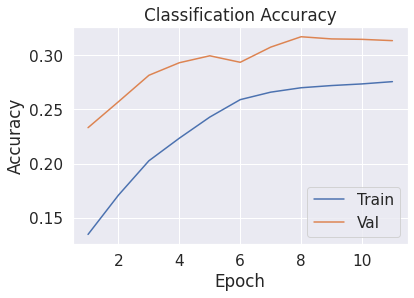

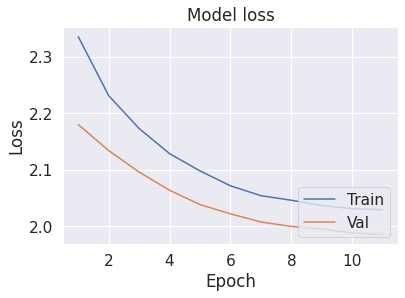

In [59]:
plot_metrics(history4)

In [60]:
predicted_test_RN = model_RN.predict(x_val, batch_size=32)

In [61]:
class_pred_test_RN = [np.argmax(i) for i in predicted_test_RN]

In [62]:
from sklearn.metrics import classification_report
report = classification_report([np.argmax(i) for i in y_val], class_pred_test_RN)
print(report)

              precision    recall  f1-score   support

           0       0.31      0.41      0.36       258
           1       0.33      0.35      0.34       252
           2       0.24      0.23      0.24       236
           3       0.20      0.03      0.05       286
           4       0.26      0.35      0.30       221
           5       0.33      0.48      0.39       282
           6       0.32      0.16      0.21       244
           7       0.29      0.35      0.32       240
           8       0.37      0.40      0.39       233
           9       0.39      0.39      0.39       248

    accuracy                           0.31      2500
   macro avg       0.30      0.32      0.30      2500
weighted avg       0.30      0.31      0.30      2500



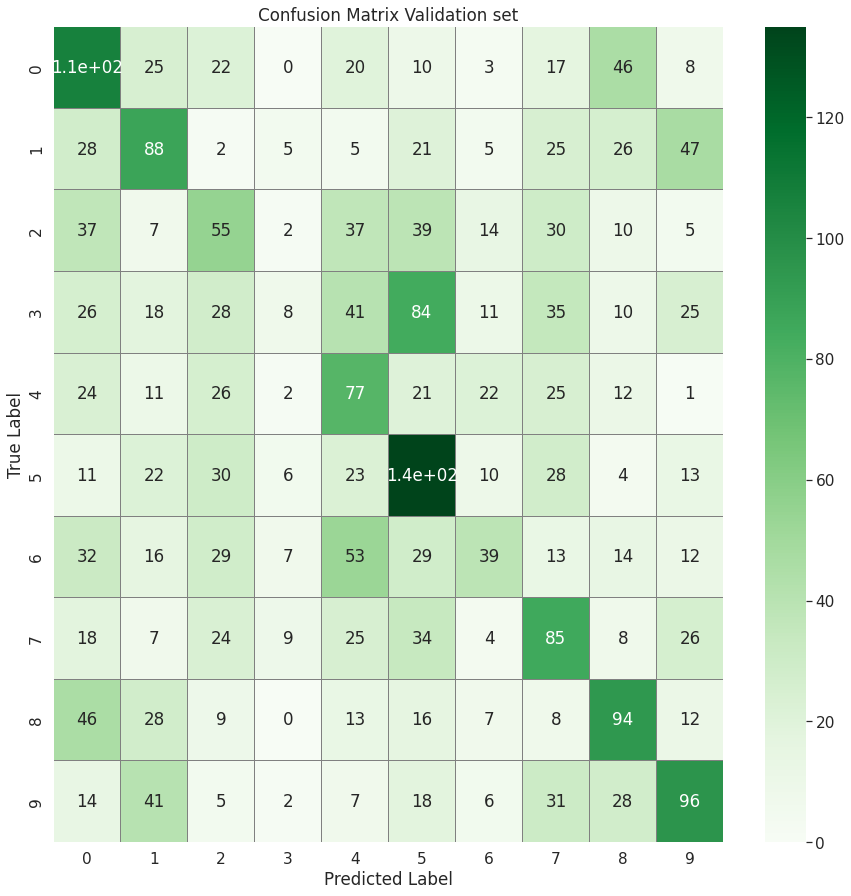

In [63]:
from sklearn.metrics import confusion_matrix

f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx = confusion_matrix([np.argmax(i) for i in y_val], class_pred_test_RN)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [64]:
acc = model_RN.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

313/313 [==============================] - 5s 15ms/step - loss: 1.9762 - accuracy: 0.3154
test set loss :  1.9761990308761597
test set accuracy : 31.540000438690186


In [65]:
acc1 = model.evaluate (x_train, y_train)
print("training set loss : " , acc1[0])
print("training set accuracy :", acc1[1]*100)

1485/1485 [==============================] - 5s 3ms/step - loss: 0.4583 - accuracy: 0.8442
training set loss :  0.4582798480987549
training set accuracy : 84.42105054855347


## MobileNet

In [66]:
from tensorflow.keras.applications import MobileNet

In [67]:
model_MN=Sequential()
model_MN.add(MobileNet(input_shape=(32,32,3),
                       include_top=False,
                       weights='imagenet',
                       pooling='max'))

17235968/17225924 [==============================] - 0s 0us/step


In [68]:
model_MN.layers[0].trainable=False

In [69]:
model_MN.add(Dense(512,activation='relu'))
model_MN.add(Dropout(0.1))
model_MN.add(Dense(10,activation='softmax'))

In [70]:
model_MN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 3,758,794
Trainable params: 529,930
Non-trainable params: 3,228,864
_________________________________________________________________


In [71]:
model_MN.layers

In [72]:
model_MN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
epoch = 20
history6 = model_MN.fit(datagen.flow(x_train, y_train, batch_size = 32), 
                        epochs = epoch, validation_data = (x_val, y_val), 
                        verbose = 1, callbacks=[callbacks, lr_reduction, early_stopping])

Epoch 1/20
1485/1485 [==============================] - 29s 19ms/step - loss: 2.3144 - accuracy: 0.0909 - val_loss: 2.3073 - val_accuracy: 0.0996 - lr: 1.0000e-06
Epoch 2/20
1485/1485 [==============================] - 27s 18ms/step - loss: 2.3082 - accuracy: 0.0973 - val_loss: 2.3030 - val_accuracy: 0.1076 - lr: 1.0000e-06
Epoch 3/20
1485/1485 [==============================] - 28s 19ms/step - loss: 2.3045 - accuracy: 0.1029 - val_loss: 2.2992 - val_accuracy: 0.1260 - lr: 1.0000e-06
Epoch 4/20
1485/1485 [==============================] - 28s 19ms/step - loss: 2.3009 - accuracy: 0.1111 - val_loss: 2.2958 - val_accuracy: 0.1236 - lr: 1.0000e-06
Epoch 5/20
1485/1485 [==============================] - 28s 19ms/step - loss: 2.2972 - accuracy: 0.1179 - val_loss: 2.2926 - val_accuracy: 0.1628 - lr: 1.0000e-06
Epoch 6/20
1485/1485 [==============================] - 28s 19ms/step - loss: 2.2945 - accuracy: 0.1245 - val_loss: 2.2897 - val_accuracy: 0.1628 - lr: 1.0000e-06
Epoch 7/20
1485/1485 [

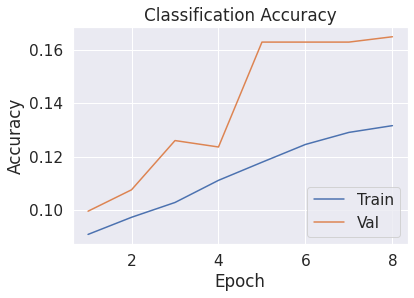

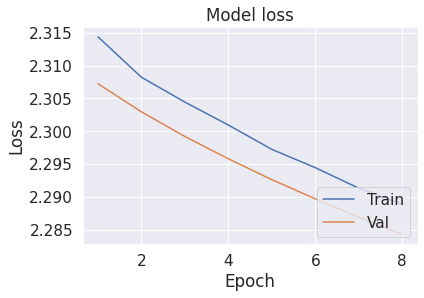

In [74]:
plot_metrics(history6)

In [75]:
predicted_test_MN = model_MN.predict(x_val, batch_size=32)

In [76]:
class_pred_test_MN = [np.argmax(i) for i in predicted_test_MN]

In [77]:
from sklearn.metrics import classification_report
report = classification_report([np.argmax(i) for i in y_val], class_pred_test_MN)
print(report)

              precision    recall  f1-score   support

           0       0.16      0.74      0.26       258
           1       0.37      0.05      0.09       252
           2       0.11      0.33      0.17       236
           3       0.22      0.33      0.26       286
           4       0.25      0.00      0.01       221
           5       0.49      0.07      0.12       282
           6       0.18      0.05      0.08       244
           7       0.25      0.00      0.01       240
           8       0.27      0.01      0.02       233
           9       0.00      0.00      0.00       248

    accuracy                           0.16      2500
   macro avg       0.23      0.16      0.10      2500
weighted avg       0.23      0.16      0.11      2500



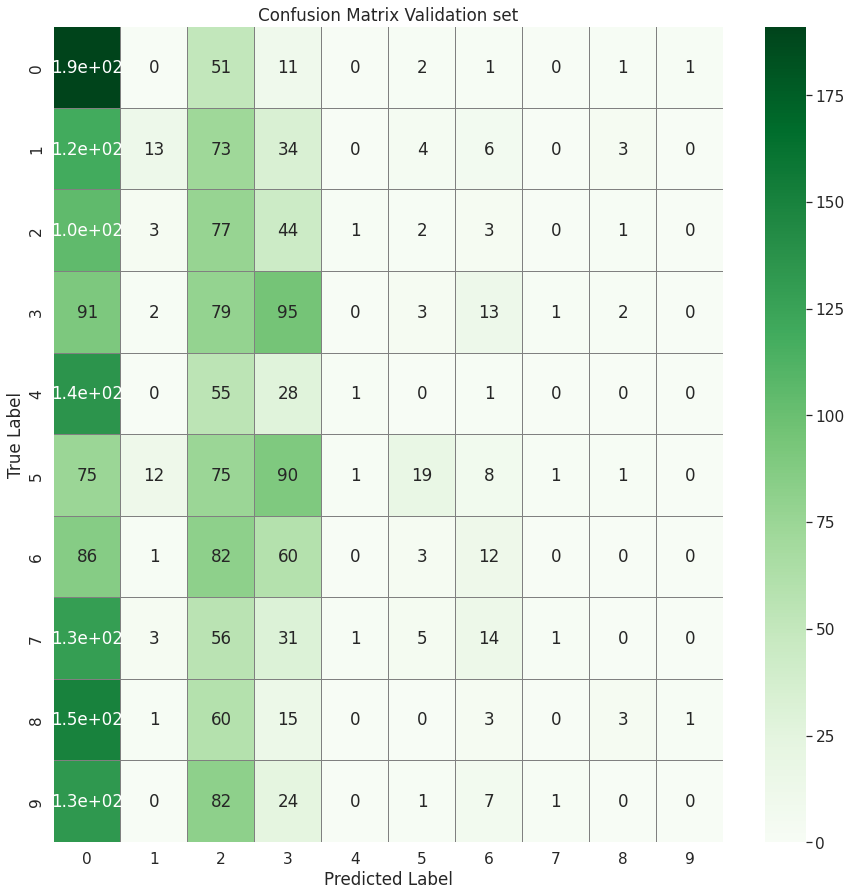

In [78]:
from sklearn.metrics import confusion_matrix

f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx = confusion_matrix([np.argmax(i) for i in y_val], class_pred_test_MN)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [79]:
acc = model_MN.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

313/313 [==============================] - 2s 6ms/step - loss: 2.2862 - accuracy: 0.1542
test set loss :  2.286229372024536
test set accuracy : 15.42000025510788


In [80]:
acc1 = model.evaluate (x_train, y_train)
print("training set loss : " , acc1[0])
print("training set accuracy :", acc1[1]*100)

1485/1485 [==============================] - 5s 3ms/step - loss: 0.4583 - accuracy: 0.8442
training set loss :  0.4582798480987549
training set accuracy : 84.42105054855347


## DenseNet121

In [81]:
from tensorflow.keras.applications import DenseNet121

In [82]:
model_DN=Sequential()
model_DN.add(DenseNet121(input_shape=(32,32,3),
             include_top=False,
             weights='imagenet',
             pooling='max'))

29097984/29084464 [==============================] - 0s 0us/step


In [83]:
model_DN.layers[0].trainable=False
#model_DN.summary()

In [84]:
model_DN.add(Dense(512,activation='relu'))
model_DN.add(Dropout(0.1))
model_DN.add(Dense(10,activation='softmax'))

In [85]:
model_DN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                5130      
                                                                 
Total params: 7,567,434
Trainable params: 529,930
Non-trainable params: 7,037,504
_________________________________________________________________


In [86]:
model_DN.layers

In [87]:
model_DN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
epoch = 20
history7 = model_DN.fit(datagen.flow(x_train, y_train, batch_size = 32), 
                        epochs = epoch, validation_data = (x_val, y_val), 
                        verbose = 1, callbacks=[callbacks, lr_reduction, early_stopping])

Epoch 1/20
1485/1485 [==============================] - 52s 31ms/step - loss: 2.4528 - accuracy: 0.1463 - val_loss: 2.2409 - val_accuracy: 0.1892 - lr: 1.0000e-06
Epoch 2/20
1485/1485 [==============================] - 43s 29ms/step - loss: 2.2156 - accuracy: 0.2065 - val_loss: 2.0869 - val_accuracy: 0.2424 - lr: 1.0000e-06
Epoch 3/20
1485/1485 [==============================] - 42s 29ms/step - loss: 2.0920 - accuracy: 0.2502 - val_loss: 1.9759 - val_accuracy: 0.2848 - lr: 1.0000e-06
Epoch 4/20
1485/1485 [==============================] - 43s 29ms/step - loss: 2.0036 - accuracy: 0.2820 - val_loss: 1.8893 - val_accuracy: 0.3276 - lr: 1.0000e-06
Epoch 5/20
1485/1485 [==============================] - 43s 29ms/step - loss: 1.9318 - accuracy: 0.3111 - val_loss: 1.8184 - val_accuracy: 0.3556 - lr: 1.0000e-06
Epoch 6/20
1485/1485 [==============================] - 42s 29ms/step - loss: 1.8658 - accuracy: 0.3330 - val_loss: 1.7617 - val_accuracy: 0.3748 - lr: 1.0000e-06
Epoch 7/20
1485/1485 [

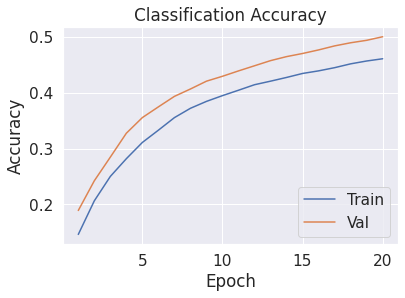

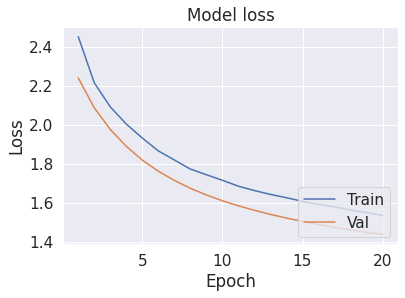

In [89]:
plot_metrics(history7)

In [90]:
predicted_test_DN = model_DN.predict(x_val, batch_size=32)

In [91]:
class_pred_test_DN = [np.argmax(i) for i in predicted_test_DN]

In [92]:
from sklearn.metrics import classification_report
report = classification_report([np.argmax(i) for i in y_val], class_pred_test_DN)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       258
           1       0.51      0.54      0.53       252
           2       0.49      0.33      0.39       236
           3       0.47      0.35      0.40       286
           4       0.49      0.38      0.43       221
           5       0.50      0.43      0.46       282
           6       0.49      0.66      0.56       244
           7       0.43      0.58      0.49       240
           8       0.57      0.59      0.58       233
           9       0.49      0.58      0.53       248

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.50      0.50      0.49      2500



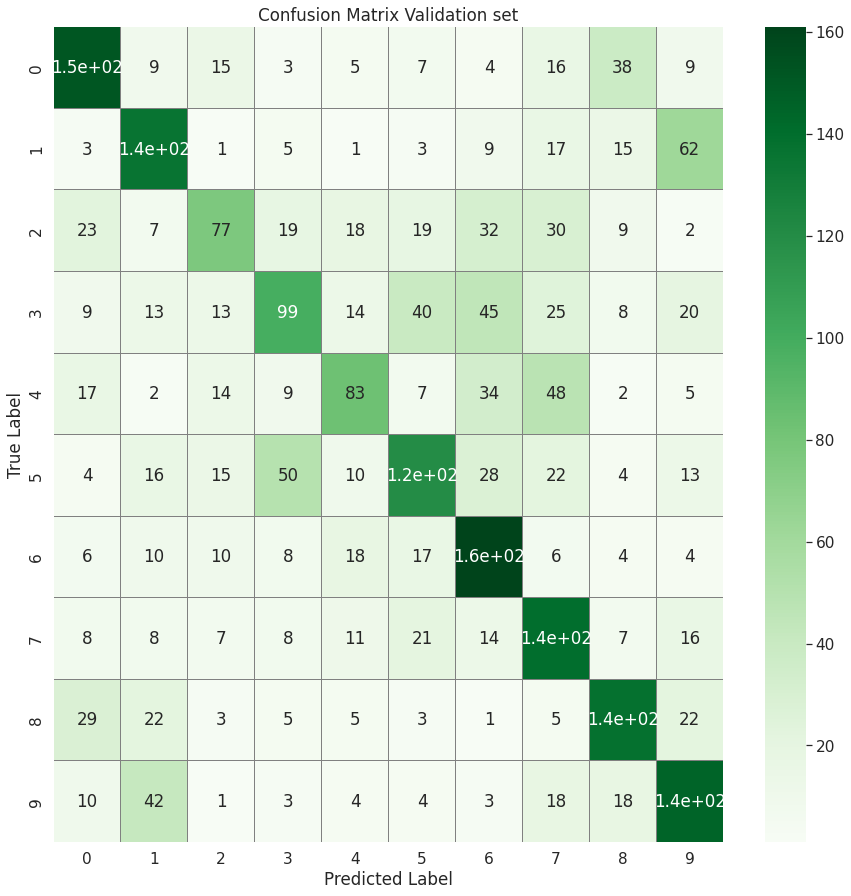

In [93]:
from sklearn.metrics import confusion_matrix

f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx = confusion_matrix([np.argmax(i) for i in y_val], class_pred_test_DN)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [94]:
acc = model_DN.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

313/313 [==============================] - 6s 19ms/step - loss: 1.4237 - accuracy: 0.5046
test set loss :  1.4236987829208374
test set accuracy : 50.45999884605408


In [95]:
acc1 = model.evaluate (x_train, y_train)
print("training set loss : " , acc1[0])
print("training set accuracy :", acc1[1]*100)

1485/1485 [==============================] - 5s 3ms/step - loss: 0.4583 - accuracy: 0.8442
training set loss :  0.4582798480987549
training set accuracy : 84.42105054855347
